# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
#!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from datasets import load_dataset 
from transformers import (
    Blip2VisionConfig,
    Blip2QFormerConfig,
    OPTConfig,
    Blip2Config,
    Blip2ForConditionalGeneration,
    #PhiConfig,
    Blip2Model,
    AutoModelForCausalLM
)
from transformers import AutoProcessor, AutoTokenizer
import bitsandbytes
from peft import LoraConfig, get_peft_model

/home/everdistant/miniconda3/envs/blip2cap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'image': Image(decode=True, id=None),
 'contest_number': Value(dtype='int32', id=None),
 'image_location': Value(dtype='string', id=None),
 'image_description': Value(dtype='string', id=None),
 'image_uncanny_description': Value(dtype='string', id=None),
 'entities': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'questions': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'caption_choices': Value(dtype='string', id=None),
 'from_description': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None),
 'n_tokens_label': Value(dtype='int32', id=None),
 'instance_id': Value(dtype='string', id=None)}

[['Is there a man stuck inside?'],
 ['Why is the book so big?', 'What is written in the book?'],
 ['Why is there a sword stuck in an office desk?', 'What is the man saying?'],
 ['Why is there a pool in an office building?'],
 ['Why are those people playing baseball in a living room?'],
 ['Why did the patient get split apart?'],
 ['Why are the dinosaurs dressed like this?'],
 ['What is the pulse reading of the giant hand?',
  'How the the hand become so big?'],
 ['Why are there statues of numeral numbers?'],
 ['Why is the turkey dressing up?'],
 ['why is there a monster?'],
 ['Why would anyone have to be bound to a chair in order to get them to have dinner?',
  'What kind of wine are they drinking?'],
 ['Why is the couch a monster?'],
 ['Are the people on the bike speaking to each other on their cell phones?',
  'Why would they choose a bike that long to ride?'],
 ['Why is the man so obsessed with his own image?'],
 ['Why is the dog walking and wearing clothes like a person?',
  'What i

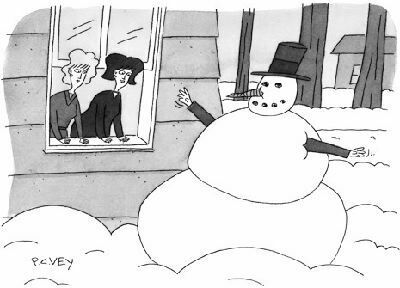

In [3]:
dataset = load_dataset("jmhessel/newyorker_caption_contest", 'explanation', split="train[:25]")
dataset


display(dataset.features)
display(dataset['questions'])
display(dataset[0]["image"])

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [4]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["questions"][0]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [5]:
base_model_27 = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", 
    device_map="auto", load_in_8bit=True)

model_27 = get_peft_model(base_model_27, LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "crossattention.attention.query",
        "crossattention.attention.key",
        #"language_projection"
    ],
))

model_27.print_trainable_parameters()
display(model_27.language_projection)
display(model_27.language_model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

trainable params: 356,352 || all params: 3,745,036,288 || trainable%: 0.009515315008878226


Linear8bitLt(in_features=768, out_features=2560, bias=True)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2560, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2560)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
            (out_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True

In [6]:
# base_model_13 = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", 
#     device_map="auto", load_in_8bit=True)
# original_language_projection = base_model_13.language_projection
# display(base_model_13)

# opt_1_3_lm = AutoModelForCausalLM.from_pretrained('facebook/opt-1.3b',
#     trust_remote_code=False,
#     device_map='auto',load_in_8bit=True

# )
# base_model_13.language_model = opt_1_3_lm
# base_model_13.language_projection = bitsandbytes.nn.Linear8bitLt(
#     original_language_projection.in_features, 2048).to(base_model_13.device)
# base_model_13.post_init()

# display(base_model_13)

# model_13 = get_peft_model(base_model_13, LoraConfig(
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="none",
#     target_modules=[
#         # "crossattention.attention.query",
#         # "crossattention.attention.key",
#         "language_projection"
#     ],
# ))

# model_13.print_trainable_parameters()
# display(model_13.language_projection)
# display(model_13.language_model)

Target caption: ['Why is the book so big?', 'What is written in the book?']


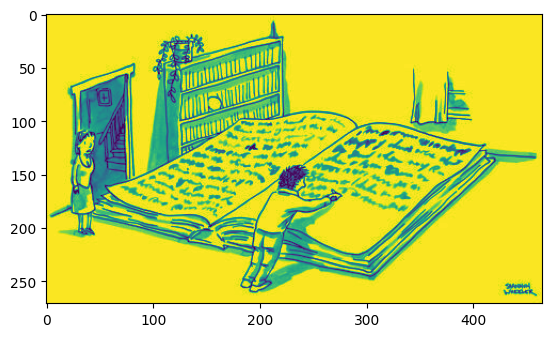

In [7]:
IDX = 1

example = dataset[IDX]
print(f"Target caption: {dataset['questions'][IDX]}")
example_image = example["image"]
plt.imshow(example_image)

## Train the model

In [8]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)
optimizer = torch.optim.Adam(model_27.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Target caption: {dataset['questions'][IDX]}")
example_inputs = processor(images=example_image, return_tensors="pt").to(device, torch.float16)
example_pixel_values = example_inputs.pixel_values

tokenizer = AutoTokenizer.from_pretrained('Salesforce/blip2-opt-2.7b')
example_generated_ids = model_27.generate(pixel_values=example_pixel_values, max_length=25)
example_generated_caption = tokenizer.batch_decode(example_generated_ids, skip_special_tokens=True)[0]
print(example_generated_caption)

for epoch in tqdm(range(100)):
  model_27.train()
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model_27(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    model_27.eval()
    example_generated_ids = model_27.generate(pixel_values=example_pixel_values, max_length=25)
    example_generated_caption = tokenizer.batch_decode(example_generated_ids, skip_special_tokens=True)[0]
    print(f"Loss: {loss.item():.4f} Caption: {example_generated_caption}")

Target caption: ['Why is the book so big?', 'What is written in the book?']
a man is writing on a large book



  1%|          | 1/100 [00:04<08:10,  4.95s/it]

Loss: 3.7832 Caption: a man is writing on a large book



  2%|▏         | 2/100 [00:10<08:16,  5.07s/it]

Loss: 5.3477 Caption: a man is writing on a large book in a room



  3%|▎         | 3/100 [00:15<08:30,  5.26s/it]

Loss: 3.2773 Caption: a man is writing on a large book in a room with a woman



  4%|▍         | 4/100 [00:20<08:29,  5.31s/it]

Loss: 4.6914 Caption: a man is writing on a large book in a room with a woman



  5%|▌         | 5/100 [00:26<08:37,  5.45s/it]

Loss: 3.0859 Caption: a man is writing on a large book in a room with a bed and a



  6%|▌         | 6/100 [00:31<08:09,  5.21s/it]

Loss: 3.5684 Caption: the man is writing on the giant book



  7%|▋         | 7/100 [00:36<07:57,  5.13s/it]

Loss: 4.4023 Caption: the man is writing on the giant book



  8%|▊         | 8/100 [00:41<07:44,  5.05s/it]

Loss: 3.9512 Caption: the man is writing on the giant book



  9%|▉         | 9/100 [00:46<07:34,  4.99s/it]

Loss: 3.4355 Caption: the man is writing on the giant book



 10%|█         | 10/100 [00:50<07:23,  4.92s/it]

Loss: 2.5625 Caption: ``i'm writing a book''



 11%|█         | 11/100 [00:56<07:28,  5.04s/it]

Loss: 2.4629 Caption: ``i'm sorry, i didn't mean to scare you''



 12%|█▏        | 12/100 [01:01<07:38,  5.21s/it]

Loss: 3.0957 Caption: the man is reading the book and the woman is standing in front of it



 13%|█▎        | 13/100 [01:07<07:43,  5.32s/it]

Loss: 4.3477 Caption: the man is reading the book and the woman is standing in front of it



 14%|█▍        | 14/100 [01:12<07:44,  5.41s/it]

Loss: 4.2852 Caption: the man is reading the book and the woman is standing in front of it



 15%|█▌        | 15/100 [01:18<07:45,  5.48s/it]

Loss: 3.7344 Caption: the man is reading the book and the woman is standing in front of it



 16%|█▌        | 16/100 [01:24<07:42,  5.51s/it]

Loss: 3.1992 Caption: the man is reading the book and the woman is standing in front of it



 17%|█▋        | 17/100 [01:28<07:11,  5.20s/it]

Loss: 3.3301 Caption: what is this?



 18%|█▊        | 18/100 [01:32<06:38,  4.86s/it]

Loss: 4.0938 Caption: 



 19%|█▉        | 19/100 [01:38<06:50,  5.07s/it]

Loss: 2.5254 Caption: the man is standing on the bed and the woman is standing on the floor



 20%|██        | 20/100 [01:42<06:29,  4.87s/it]

Loss: 4.2539 Caption: what is this?



 21%|██        | 21/100 [01:47<06:15,  4.75s/it]

Loss: 2.3242 Caption: what is this?



 22%|██▏       | 22/100 [01:52<06:16,  4.83s/it]

Loss: 3.2676 Caption: why do you have to read the book?



 23%|██▎       | 23/100 [01:57<06:24,  4.99s/it]

Loss: 2.2129 Caption: why is there a book in the middle of the room?



 24%|██▍       | 24/100 [02:02<06:13,  4.92s/it]

Loss: 2.5918 Caption: why is the book so big?



 25%|██▌       | 25/100 [02:07<06:05,  4.87s/it]

Loss: 2.6797 Caption: why is the book so big?



 26%|██▌       | 26/100 [02:12<06:08,  4.98s/it]

Loss: 2.4414 Caption: why is there a book in the middle of the room?



 27%|██▋       | 27/100 [02:17<05:57,  4.90s/it]

Loss: 3.6328 Caption: why is the book so big?



 28%|██▊       | 28/100 [02:21<05:50,  4.87s/it]

Loss: 1.5596 Caption: why is the book so big?



 29%|██▉       | 29/100 [02:26<05:42,  4.83s/it]

Loss: 3.0156 Caption: why is the book so big?



 30%|███       | 30/100 [02:31<05:36,  4.80s/it]

Loss: 2.9590 Caption: why is the book so big?



 31%|███       | 31/100 [02:36<05:31,  4.80s/it]

Loss: 2.2715 Caption: Why is the book so big?



 32%|███▏      | 32/100 [02:41<05:36,  4.94s/it]

Loss: 1.1611 Caption: why is there a book in the middle of the room?



 33%|███▎      | 33/100 [02:46<05:38,  5.05s/it]

Loss: 3.3203 Caption: why is there a book in the middle of the room?



 34%|███▍      | 34/100 [02:51<05:28,  4.97s/it]

Loss: 1.7197 Caption: why is the book so big?



 35%|███▌      | 35/100 [02:56<05:19,  4.92s/it]

Loss: 1.8477 Caption: why is the book so big?



 36%|███▌      | 36/100 [03:01<05:13,  4.89s/it]

Loss: 2.6895 Caption: why is the book so big?



 37%|███▋      | 37/100 [03:05<05:05,  4.85s/it]

Loss: 2.5254 Caption: Why is the book so big?



 38%|███▊      | 38/100 [03:10<05:00,  4.85s/it]

Loss: 2.9277 Caption: Why is the book so big?



 39%|███▉      | 39/100 [03:15<04:51,  4.78s/it]

Loss: 2.2070 Caption: Why is the book so big?



 40%|████      | 40/100 [03:20<04:45,  4.76s/it]

Loss: 2.3652 Caption: Why is the book so big?



 41%|████      | 41/100 [03:24<04:39,  4.73s/it]

Loss: 2.0332 Caption: Why is the book so big?



 42%|████▏     | 42/100 [03:29<04:34,  4.73s/it]

Loss: 2.4512 Caption: Why is the book so big?



 43%|████▎     | 43/100 [03:34<04:29,  4.73s/it]

Loss: 1.9941 Caption: Why is the book so big?



 44%|████▍     | 44/100 [03:38<04:22,  4.69s/it]

Loss: 2.4160 Caption: Why is the book so big?



 45%|████▌     | 45/100 [03:43<04:18,  4.70s/it]

Loss: 1.8057 Caption: Why is the book so big?



 46%|████▌     | 46/100 [03:48<04:15,  4.73s/it]

Loss: 1.4287 Caption: Why is the book so big?



 47%|████▋     | 47/100 [03:53<04:18,  4.87s/it]

Loss: 1.3750 Caption: Why is there a book in the middle of the room?



 48%|████▊     | 48/100 [03:58<04:10,  4.81s/it]

Loss: 1.2861 Caption: Why is the book so big?



 49%|████▉     | 49/100 [04:02<04:03,  4.78s/it]

Loss: 0.9331 Caption: Why is the book so big?



 50%|█████     | 50/100 [04:07<03:58,  4.77s/it]

Loss: 2.4023 Caption: Why is the book so big?



 51%|█████     | 51/100 [04:12<03:53,  4.77s/it]

Loss: 1.6357 Caption: Why is the book so big?



 52%|█████▏    | 52/100 [04:17<03:48,  4.76s/it]

Loss: 1.6758 Caption: Why is the book so big?



 53%|█████▎    | 53/100 [04:21<03:44,  4.77s/it]

Loss: 0.8604 Caption: Why is the book so big?



 54%|█████▍    | 54/100 [04:26<03:41,  4.81s/it]

Loss: 1.9277 Caption: Why is the book so big?



 55%|█████▌    | 55/100 [04:32<03:43,  4.96s/it]

Loss: 1.4414 Caption: Why is there a book in the middle of the room?



 56%|█████▌    | 56/100 [04:37<03:41,  5.04s/it]

Loss: 2.7812 Caption: Why is there a book in the middle of the room?



 57%|█████▋    | 57/100 [04:42<03:33,  4.96s/it]

Loss: 1.9893 Caption: Why is the book so big?



 58%|█████▊    | 58/100 [04:46<03:25,  4.90s/it]

Loss: 1.7666 Caption: Why is the book so big?



 59%|█████▉    | 59/100 [04:51<03:19,  4.86s/it]

Loss: 2.1367 Caption: Why is the book so big?



 60%|██████    | 60/100 [04:56<03:13,  4.83s/it]

Loss: 0.5522 Caption: Why is the book so big?



 61%|██████    | 61/100 [05:01<03:07,  4.80s/it]

Loss: 0.8486 Caption: Why is the book so big?



 62%|██████▏   | 62/100 [05:06<03:03,  4.84s/it]

Loss: 2.7129 Caption: Why is the book so big?



 63%|██████▎   | 63/100 [05:10<02:58,  4.82s/it]

Loss: 2.1270 Caption: Why is the book so big?



 64%|██████▍   | 64/100 [05:16<02:58,  4.97s/it]

Loss: 2.2500 Caption: Why is there a book in the middle of the room?



 65%|██████▌   | 65/100 [05:20<02:52,  4.92s/it]

Loss: 0.9043 Caption: Why is the book so big?



 66%|██████▌   | 66/100 [05:26<02:51,  5.03s/it]

Loss: 2.6934 Caption: Why is there a book in the middle of the room?



 67%|██████▋   | 67/100 [05:31<02:48,  5.11s/it]

Loss: 2.4160 Caption: Why is there a book in the middle of the room?



 68%|██████▊   | 68/100 [05:36<02:45,  5.17s/it]

Loss: 1.3564 Caption: Why is there a book in the middle of the room?



 69%|██████▉   | 69/100 [05:42<02:41,  5.21s/it]

Loss: 2.0918 Caption: Why is there a book in the middle of the room?



 70%|███████   | 70/100 [05:47<02:38,  5.27s/it]

Loss: 1.0176 Caption: Why is there a book in the middle of the room?



 71%|███████   | 71/100 [05:52<02:32,  5.27s/it]

Loss: 2.1250 Caption: Why is there a book in the middle of the room?



 72%|███████▏  | 72/100 [05:57<02:25,  5.19s/it]

Loss: 1.8984 Caption: Why is there a book in the house?



 73%|███████▎  | 73/100 [06:02<02:18,  5.14s/it]

Loss: 1.7471 Caption: Why is there a book in the house?



 74%|███████▍  | 74/100 [06:07<02:10,  5.02s/it]

Loss: 2.2090 Caption: Why is the book so big?



 75%|███████▌  | 75/100 [06:12<02:03,  4.93s/it]

Loss: 2.1699 Caption: Why is the book so big?



 76%|███████▌  | 76/100 [06:17<01:57,  4.89s/it]

Loss: 0.9370 Caption: Why is the book so big?



 77%|███████▋  | 77/100 [06:21<01:51,  4.87s/it]

Loss: 0.4146 Caption: Why is the book so big?



 78%|███████▊  | 78/100 [06:26<01:47,  4.87s/it]

Loss: 0.6279 Caption: Why is the book so big?



 79%|███████▉  | 79/100 [06:31<01:41,  4.84s/it]

Loss: 0.9849 Caption: Why is the book so big?



 80%|████████  | 80/100 [06:36<01:36,  4.82s/it]

Loss: 1.4336 Caption: Why is the book so big?



 81%|████████  | 81/100 [06:41<01:31,  4.81s/it]

Loss: 0.7417 Caption: Why is the book so big?



 82%|████████▏ | 82/100 [06:45<01:26,  4.80s/it]

Loss: 1.8926 Caption: Why is the book so big?



 83%|████████▎ | 83/100 [06:50<01:21,  4.79s/it]

Loss: 1.9199 Caption: Why is the book so big?



 84%|████████▍ | 84/100 [06:55<01:16,  4.79s/it]

Loss: 1.9834 Caption: Why is the book so big?



 85%|████████▌ | 85/100 [07:00<01:11,  4.78s/it]

Loss: 1.5850 Caption: Why is the book so big?



 86%|████████▌ | 86/100 [07:05<01:07,  4.81s/it]

Loss: 0.4688 Caption: Why is the book so big?



 87%|████████▋ | 87/100 [07:09<01:02,  4.80s/it]

Loss: 0.4126 Caption: Why is the book so big?



 88%|████████▊ | 88/100 [07:14<00:57,  4.79s/it]

Loss: 0.6509 Caption: Why is the book so big?



 89%|████████▉ | 89/100 [07:19<00:52,  4.78s/it]

Loss: 2.1348 Caption: Why is the book so big?



 90%|█████████ | 90/100 [07:24<00:47,  4.79s/it]

Loss: 1.7432 Caption: Why is the book so big?



 91%|█████████ | 91/100 [07:29<00:43,  4.79s/it]

Loss: 0.7637 Caption: Why is the book so big?



 92%|█████████▏| 92/100 [07:34<00:39,  4.94s/it]

Loss: 1.3887 Caption: Why is there a book in the middle of the room?



 93%|█████████▎| 93/100 [07:39<00:34,  4.89s/it]

Loss: 1.8652 Caption: Why is the book so big?



 94%|█████████▍| 94/100 [07:43<00:29,  4.90s/it]

Loss: 2.0176 Caption: Why is the book so big?



 95%|█████████▌| 95/100 [07:48<00:24,  4.85s/it]

Loss: 0.9375 Caption: Why is the book so big?



 96%|█████████▌| 96/100 [07:53<00:19,  4.84s/it]

Loss: 0.6768 Caption: Why is the book so big?



 97%|█████████▋| 97/100 [07:58<00:14,  4.89s/it]

Loss: 1.4023 Caption: Why is there a book in the house?



 98%|█████████▊| 98/100 [08:03<00:09,  4.93s/it]

Loss: 1.6309 Caption: Why is there a book in the house?



 99%|█████████▉| 99/100 [08:08<00:04,  4.97s/it]

Loss: 0.5562 Caption: Why is there a book in the house?



100%|██████████| 100/100 [08:13<00:00,  4.93s/it]

Loss: 1.7393 Caption: Why is the book so big?



## Save LoRA

In [9]:
merged_model_27 = model_27.merge_and_unload()
merged_model_27.save_pretrained("../models/merged_model_27.hf", save_adapter=True, save_config=True)

/home/everdistant/miniconda3/envs/blip2cap/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:83: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
/home/everdistant/miniconda3/envs/blip2cap/lib/python3.10/site-packages/transformers/modeling_utils.py:2288: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Removed shared tensor {'language_model.model.decoder.layers.1.self_attn.out_proj.weight_format', 'language_model.model.decoder.layers.8.fc2.weight_format', 'vision_model.encoder.layers.33.mlp.fc1.weight_format', 'qformer.encoder.layer.10.crossattention.attention.query.weight_format', 'qformer.encoder.layer.7.output_query.dense.weight_format', 'language_model.model.decoder.layers.3.self_attn.v_proj.weight_format', 'vision_model.encoder.layers.19.mlp.fc1.weight_format', 'qformer.encoder.layer.3.output_query.dense.weight_format', 'vision_